In [1]:
import tensorflow as tf; print(tf.__version__)

2.1.0


In [2]:
import nest_asyncio
nest_asyncio.apply()
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tqdm import tqdm
from pathlib import Path

from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
def plot_graph(X, y, format = '-', label=''):
    plt.plot(X, y, format, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.grid(True)
np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

experiment_name = "xray_image_dataset"
method = "tff_training"
this_dir = Path.cwd()
model_dir = this_dir / "saved_models" / experiment_name / method
output_dir = this_dir / "results" / experiment_name / method

In [6]:


# Data generators
train_dir='Data/train/'
validation_dir='Data/test/'
batch_size=10

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen =  ImageDataGenerator(
      rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 32x32
        target_size=(32, 32),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical', color_mode = "grayscale")

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical', color_mode = "grayscale")

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [7]:

# Store the data in X_train, y_train variables by iterating over the batches
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm(range(int(len(train_generator))-1)): #1st batch is already fetched before the for loop.
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)


100%|██████████| 514/514 [02:49<00:00,  3.03it/s]

(5144, 32, 32, 1) (5144, 3)


In [8]:

validation_generator.reset()
X_test, y_test = next(validation_generator)
for i in tqdm(range(int(len(validation_generator))-1)): #1st batch is already fetched before the for loop.
    img, label = next(validation_generator)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(X_test.shape, y_test.shape)


100%|██████████| 128/128 [00:44<00:00,  2.88it/s]

(1288, 32, 32, 1) (1288, 3)


In [9]:
X_test = X_test.astype(np.float32)
y_test =  np.argmax(y_test, axis=-1).reshape([1288,1]).astype(np.int32)


In [10]:
X_train = X_train.astype(np.float32)
y_train =  np.argmax(y_train, axis=-1).reshape([5144,1]).astype(np.int32)

In [11]:
y_train

array([[2],
       [2],
       [2],
       ...,
       [1],
       [2],
       [2]], dtype=int32)

In [17]:

split=10 #Number of clients 
total_image_count = len(X_train)
image_per_set = int(np.floor(total_image_count/split))

In [18]:
client_train_dataset = collections.OrderedDict()
for i in range(1, split+1):
    client_name = "client_" + str(i)
    start = image_per_set * (i-1)
    end = image_per_set * i

    print(f"Adding data from {start} to {end} for client : {client_name}")
    data = collections.OrderedDict((('label', y_train[start:end]), ('pixels', X_train[start:end])))
    client_train_dataset[client_name] = data



Adding data from 0 to 514 for client : client_1
Adding data from 514 to 1028 for client : client_2
Adding data from 1028 to 1542 for client : client_3
Adding data from 1542 to 2056 for client : client_4
Adding data from 2056 to 2570 for client : client_5
Adding data from 2570 to 3084 for client : client_6
Adding data from 3084 to 3598 for client : client_7
Adding data from 3598 to 4112 for client : client_8
Adding data from 4112 to 4626 for client : client_9
Adding data from 4626 to 5140 for client : client_10


In [19]:


from tensorflow import reshape, nest, config
NUM_EPOCHS=10
BATCH_SIZE=10
PREFETCH_BUFFER = 10

print(len(client_train_dataset))


train_dataset = tff.simulation.FromTensorSlicesClientData(client_train_dataset)

sample_dataset = train_dataset.create_tf_dataset_for_client(train_dataset.client_ids[0])
#print(sample_dataset['pixels'])
sample_element = next(iter(sample_dataset))

SHUFFLE_BUFFER = image_per_set

def preprocess(dataset):

    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        print(element['pixels'].get_shape())
        return collections.OrderedDict(
            x=reshape(element['pixels'], [-1, 32, 32, 1]),
            y=reshape(element['label'], [-1, 1]))



    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
        BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)


preprocessed_sample_dataset = preprocess(sample_dataset)
sample_batch = nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_sample_dataset)))


def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

federated_train_data = make_federated_data(train_dataset, train_dataset.client_ids)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))


10
(None, 32, 32, 1)
(None, 32, 32, 1)
(None, 32, 32, 1)
(None, 32, 32, 1)
(None, 32, 32, 1)
(None, 32, 32, 1)
(None, 32, 32, 1)
(None, 32, 32, 1)
(None, 32, 32, 1)
(None, 32, 32, 1)
(None, 32, 32, 1)
Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 32, 32, 1)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout


def create_keras_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        #MaxPool2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')

    ])
    return model


In [21]:

import collections
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow import reshape, nest, config
from tensorflow.keras import losses, metrics, optimizers
import tensorflow_federated as tff
from matplotlib import pyplot as plt
from pathlib import Path

method = "tff_training"
client_lr = 1e-3
server_lr = 1e-3
NUM_ROUNDS = 10


def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.

    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=losses.SparseCategoricalCrossentropy(),
      metrics=[metrics.SparseCategoricalAccuracy()])


iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: optimizers.RMSprop(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.Adagrad(learning_rate=server_lr))

print(str(iterative_process.initialize.type_signature))

state = iterative_process.initialize()

tff_train_acc = []
tff_val_acc = []
tff_train_loss = []
tff_val_loss = []

eval_model = None
for round_num in range(1, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    eval_model = create_keras_model()
    eval_model.compile(optimizer=optimizers.Adam(learning_rate=client_lr),
                       loss=losses.SparseCategoricalCrossentropy(),
                       metrics=[metrics.SparseCategoricalAccuracy()])

    tff.learning.assign_weights_to_keras_model(eval_model, state.model)

    ev_result = eval_model.evaluate(X_test, y_test, verbose=0)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))
    print(f"Eval loss : {ev_result[0]} and Eval accuracy : {ev_result[1]}")
    tff_train_acc.append(float(tff_metrics.sparse_categorical_accuracy))
    tff_val_acc.append(ev_result[1])
    tff_train_loss.append(float(tff_metrics.loss))
    tff_val_loss.append(ev_result[0])

metric_collection = {"sparse_categorical_accuracy": tff_train_acc,
                     "val_sparse_categorical_accuracy": tff_val_acc,
                     "loss": tff_train_loss,
                     "val_loss": tff_val_loss}

( -> <model=<trainable=<float32[3,3,1,32],float32[32],float32[3,3,32,32],float32[32],float32[6272,32],float32[32],float32[32,64],float32[64],float32[64,3],float32[3]>,non_trainable=<>>,optimizer_state=<int64,float32[3,3,1,32],float32[32],float32[3,3,32,32],float32[32],float32[6272,32],float32[32],float32[32,64],float32[64],float32[64,3],float32[3]>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)
round  1, metrics=<sparse_categorical_accuracy=0.7220427989959717,loss=0.6473367810249329,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.1191434260480893 and Eval accuracy : 0.09006211161613464
round  2, metrics=<sparse_categorical_accuracy=0.7216536998748779,loss=0.647875964641571,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.1175583986021718 and Eval accuracy : 0.09006211161613464
round  3, metrics=<sparse_categorical_accuracy=0.7314397096633911,loss=0.6290926933288574,keras_training_time_client_sum_sec=0.0>
Eval loss : 1.1153205033414852 and Eval accuracy : 0.090062

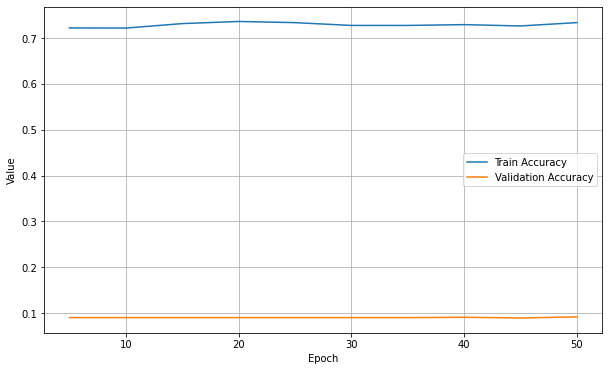

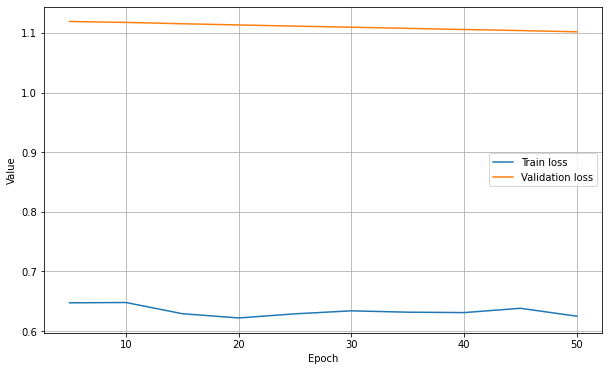

In [22]:

fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, 51))[4::5], tff_train_acc, label='Train Accuracy')
plot_graph(list(range(1, 51))[4::5], tff_val_acc, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, 51))[4::5], tff_train_loss, label='Train loss')
plot_graph(list(range(1, 51))[4::5], tff_val_loss, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model_loss.png")


In [16]:
# saving metric values to text file

txt_file_path = output_dir / (experiment_name + ".txt")
with open(txt_file_path.as_posix(), "w") as handle:
    content = []
    for key, val in metric_collection.items():
        line_content = key
        val = [str(k) for k in val]
        line_content = line_content + " " + " ".join(val)
        content.append(line_content)
    handle.write("\n".join(content))

In [23]:
y_pred = eval_model.predict(X_test)
y_prediction_test=np.argmax(y_pred, axis=-1)


y_pred = eval_model.predict(X_train)
y_prediction_train=np.argmax(y_pred, axis=-1)


              precision    recall  f1-score   support

           0       0.09      0.95      0.16       116
           1       0.00      0.00      0.00       317
           2       0.25      0.01      0.02       855

    accuracy                           0.09      1288
   macro avg       0.11      0.32      0.06      1288
weighted avg       0.17      0.09      0.03      1288



/Users/sreedevic/anaconda3/envs/tensorflow-old/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sreedevic/anaconda3/envs/tensorflow-old/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sreedevic/anaconda3/envs/tensorflow-old/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

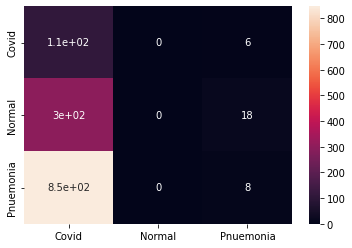

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
matrix=confusion_matrix(y_test,y_prediction_test)
import seaborn as sns
x_axis_labels = ['Covid','Normal','Pnuemonia'] # labels for x-axis
y_axis_labels = ['Covid','Normal','Pnuemonia']# labels for y-axis

# create seabvorn heatmap with required labels
sns.heatmap(matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels,annot=True)


print(classification_report(y_test,y_prediction_test))

              precision    recall  f1-score   support

           0       0.09      0.96      0.16       460
           1       0.00      0.00      0.00      1266
           2       0.53      0.03      0.06      3418

    accuracy                           0.11      5144
   macro avg       0.21      0.33      0.07      5144
weighted avg       0.36      0.11      0.05      5144



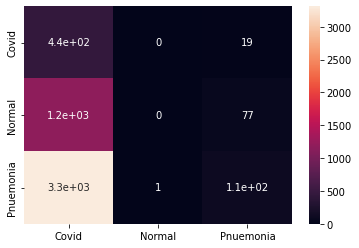

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
matrix=confusion_matrix(y_train,y_prediction_train)
import seaborn as sns
x_axis_labels = ['Covid','Normal','Pnuemonia'] # labels for x-axis
y_axis_labels = ['Covid','Normal','Pnuemonia']# labels for y-axis

# create seabvorn heatmap with required labels
sns.heatmap(matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels,annot=True)



print(classification_report(y_train,y_prediction_train))